In [2]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
import cv2
import pandas as pd
from PIL import Image
import os
import numpy as np
from google.cloud import storage
import shutil
from datetime import datetime

bucket_name = "bucket-tfg"
storage_client = storage.Client()
bucket = storage_client.get_bucket(bucket_name)

In [5]:
# Funció per obtenir les imatges de la base de dades i guardar-les a una variable diccionari
def afegir_imatges(divisio,id):
    camera = ['A','B','C','D']
    dicc_im_id = {'A': [], 'B': [], 'C': [], 'D': []}

    for i in range(len(camera)):
        llista_camera = []
        capture = cv2.VideoCapture('https://storage.googleapis.com/nutrition5k_dataset/nutrition5k_dataset/imagery/side_angles/' + id + '/camera_' + camera[i] + '.h264')
        cont = 0
        num_frames = 0

        while (capture.isOpened()):
            ret, frame = capture.read()
            if (ret == True):

                im = frame[:,:,::-1]
                im = Image.fromarray((im).astype(np.uint8))
                im = crop_area(im,224,224)

                # No afegir més de 50 imatges per càmera
                if len(llista_camera) < 50:
                    llista_camera.append(im)
                else:
                    pass

                cont += 1
                if (cv2.waitKey(1) == ord('s')):
                    break
            else:
                break

        dicc_im_id[camera[i]] = llista_camera

        capture.release()
        cv2.destroyAllWindows()

    dir_im = {'A': dicc_im_id['A'], 'B': dicc_im_id['B'], 'C': dicc_im_id['C'], 'D': dicc_im_id['D']}
    divisio.append(dir_im)

  # Funció per retallar imatge i reduïr el tamany de la imatge
# Es retalla abans de guardar-la com a variable per tal de reduïr la memòria RAM ocupada. La relació d'aspecte es conserva.

def crop_area(img0, imgf_width, imgf_height):

    imgf_res = imgf_width/imgf_height
    img0_width = img0.size[0]
    img0_height = img0.size[1]
    img0_res = img0_width/img0_height

    if imgf_res < img0_res:

        # Retallar amplada
        # En píxels: area = (left, upper, right, lower)
        cut_dist_side = (img0_width - (img0_height * imgf_res)) / 2.0
        area = (round(cut_dist_side,0), 0, round(img0_width - cut_dist_side,0), img0_height)
        img = img0.crop(area)

    if imgf_res > img0_res:

        # Retallar altura
        # En píxels: area = (left, upper, right, lower)
        cut_dist_height = (img0_height - (img0_width / imgf_res)) / 2.0
        area = (0, round(cut_dist_height,0), img0_width, round(img0_height - cut_dist_height, 0))
        img = img0.crop(area)

    else:
        area = (0,0,img0_width,img0_height)

    return img.resize((imgf_width,imgf_height), Image.ANTIALIAS)

In [30]:
# Llista mostres de train
blob = bucket.get_blob('Nutrition5k dataset/train_ids.txt')
blob = blob.download_to_filename('train_ids')
with open('train_ids') as f:
    train_ids = f.read().splitlines()

# Llissta mostres de test
blob = bucket.get_blob('Nutrition5k dataset/test_ids.txt')
blob = blob.download_to_filename('test_ids')
with open('test_ids') as f:
    test_ids = f.read().splitlines()

In [20]:
all_ids = train_ids + test_ids
print(len(train_ids),len(test_ids),len(all_ids))

4059 709 4768


In [23]:
for f in range(48):
    n_mostres = f * 100
    
    now = datetime.now()

    current_time = now.strftime("%H:%M:%S")
    print("Current Time =", current_time, '   Num mostres = ' ,n_mostres)
    
    # Crear el diccionari 1
    dicc = {'id': [], 'cho': [], 'im': []}

    # Obtenir arxiu csv on es relaciona cada id de cada plat amb els CHO que continguin
    csv = pd.read_csv('gs://bucket-tfg/Nutrition5k dataset/dish_metadata_cafe1.csv', on_bad_lines='skip', header=None)

    # Número total de mostres
    len_dtset = len(csv)

    # Afegir ids i cho al diccionari
    for i in range(len_dtset):
        dicc['id'].append(csv[0][i])
        dicc['cho'].append(round((csv[4][i]*(1.0/100.0)-1.0),4))

    # Llista carpetes
    blobs = storage_client.list_blobs(bucket_name, prefix='Nutrition5k dataset/200ImatgesXMostra_224x224/dish', delimiter=None)
    llista_carpetes = [blob.name[:61] for blob in blobs]

    # Guardar imatges en el bucket
    l = 0
    root = 'Nutrition5k dataset/200ImatgesXMostra_224x224/'
    for i in range(n_mostres):

        # Eliminar arxius de la carpeta temporal
        folder = 'Temporal'
        for filename in os.listdir(folder):
            file_path = os.path.join(folder, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print('Failed to delete %s. Reason: %s' % (file_path, e))

        id = all_ids[i]
        if (root + id) not in llista_carpetes:
            afegir_imatges(dicc['im'],id)

            # Guardar imatges
            camera = ['A','B','C','D']
            for j in camera:
                for k in range(len(dicc['im'][l][j])):
                    dicc['im'][l][j][k].save('Temporal/' + id + '_' + j + '_' + str(k) + '.jpeg')
                    blob = bucket.blob(root + id + '/' + 'cam' + '_' + j + '_' + str(k) + '.jpeg')
                    blob.upload_from_filename('Temporal/' + id + '_' + j + '_' + str(k) + '.jpeg')
            l = l + 1

        else:
            pass

Current Time = 11:31:35    Num mostres =  0
Current Time = 11:33:08    Num mostres =  100
Current Time = 11:34:19    Num mostres =  200
Current Time = 11:35:29    Num mostres =  300
Current Time = 11:36:40    Num mostres =  400
Current Time = 11:38:02    Num mostres =  500
Current Time = 11:39:16    Num mostres =  600
Current Time = 11:40:40    Num mostres =  700
Current Time = 11:42:12    Num mostres =  800
Current Time = 11:43:35    Num mostres =  900
Current Time = 11:45:17    Num mostres =  1000
Current Time = 11:46:44    Num mostres =  1100
Current Time = 11:48:11    Num mostres =  1200
Current Time = 11:49:39    Num mostres =  1300
Current Time = 11:51:09    Num mostres =  1400
Current Time = 11:52:40    Num mostres =  1500
Current Time = 11:54:16    Num mostres =  1600
Current Time = 11:55:51    Num mostres =  1700
Current Time = 11:57:29    Num mostres =  1800
Current Time = 11:59:13    Num mostres =  1900
Current Time = 12:01:00    Num mostres =  2000
Current Time = 12:02:49  

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:69: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
[h264 @ 0x5572bfd88300] error while decoding MB 88 45, bytestream -16
[h264 @ 0x5572d42c6080] error while decoding MB 116 48, bytestream -36
[h264 @ 0x5572d1a33940] error while decoding MB 109 48, bytestream -18
[h264 @ 0x5572bffd4680] error while decoding MB 52 23, bytestream -16


Current Time = 13:02:36    Num mostres =  4400


[h264 @ 0x5572bfd88300] error while decoding MB 88 26, bytestream -24
[h264 @ 0x5572bfd88300] error while decoding MB 95 26, bytestream -6


Current Time = 13:07:19    Num mostres =  4500


[h264 @ 0x5572c0095700] error while decoding MB 85 64, bytestream -6
[h264 @ 0x5572bfeab580] error while decoding MB 68 26, bytestream -26
[h264 @ 0x5572cf991280] error while decoding MB 6 49, bytestream -6


Current Time = 13:14:23    Num mostres =  4600


[h264 @ 0x5572bfeac300] error while decoding MB 40 57, bytestream -6


Current Time = 13:22:24    Num mostres =  4700


[h264 @ 0x5572c0050700] error while decoding MB 105 24, bytestream -21


In [52]:
# Número d'imatges en el conjunt de dades
blobs = storage_client.list_blobs(bucket_name, prefix='Nutrition5k dataset/4ImatgesXMostra_224x224/d')
llista_im = [blob.name for blob in blobs]
len(llista_im)

17718

In [12]:
unique_list = []
for i in range(len(llista_im)):
    if llista_im[i][0:61] not in unique_list:
        unique_list.append(llista_im[i][0:61])

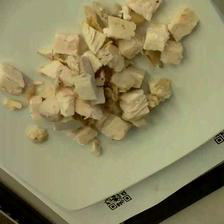

In [35]:
# Visualització d'una imatge guardada en el bucket
from io import BytesIO
# Image.open('gs://bucket-tfg/Nutrition5k dataset/200ImatgesXMostra_224x224/dish_1560455030/cam_A_0.jpeg')
blob = bucket.get_blob('Nutrition5k dataset/200ImatgesXMostra_224x224/dish_1550704750/cam_A_1.jpeg')
# blob = bucket.get_blob('bucket-tfg/Nutrition5k dataset/200ImatgesXMostra_224x224/dish_1550704750/cam_A_0.jpeg')
# blob = bucket.blob
Image.open(BytesIO(blob.download_as_bytes()))
Image.open(BytesIO((bucket.get_blob('Nutrition5k dataset/200ImatgesXMostra_224x224/dish_1550704750/cam_A_1.jpeg')).download_as_bytes()))

In [51]:
# Nou conjunt de dades amb 4 imatges per mostra
# Copiar dades del conjunt total i crear-ne un de nou amb un número reduït de dades

cameres = ['A','B','C','D']
for id in train_ids:
    for camera in cameres:
        blob = bucket.get_blob('Nutrition5k dataset/200ImatgesXMostra_224x224/' + id + '/cam_' + camera + '_0.jpeg')
        if blob != None:
            bucket.copy_blob(blob, bucket,'Nutrition5k dataset/4ImatgesXMostra_224x224/' + id + '/' + camera)
            
for id in test_ids:
    for camera in cameres:
        blob = bucket.get_blob('Nutrition5k dataset/200ImatgesXMostra_224x224/' + id + '/cam_' + camera + '_0.jpeg')
        if blob != None:
            bucket.copy_blob(blob, bucket,'Nutrition5k dataset/4ImatgesXMostra_224x224/' + id + '/' + camera)

In [47]:
print(blob)

None


In [38]:
blob = bucket.get_blob('Nutrition5k dataset/200ImatgesXMostra_224x224/' + 'id/' + 'cam_' + cam + '_1.jpeg')
bucket.copy_blob(blob, bucket,'Nutrition5k dataset/4ImatgesXMostra_224x224/' + 'dish_1550704750/' + 'A')

<Blob: bucket-tfg, Nutrition5k dataset/4ImatgesXMostra_224x224/dish_1550704750/A, 1660836464346709>

In [16]:
from io import BytesIO
Image.open(BytesIO(blob.download_as_bytes()))

NotFound: 404 GET https://storage.googleapis.com/download/storage/v1/b/bucket-tfg/o/Nutrition5k%20dataset%2F200ImatgesXMostra_224x224%2Fdish_1561996535%2Fcam_A_1.jpeg?alt=media: No such object: bucket-tfg/Nutrition5k dataset/200ImatgesXMostra_224x224/dish_1561996535/cam_A_1.jpeg: ('Request failed with status code', 404, 'Expected one of', <HTTPStatus.OK: 200>, <HTTPStatus.PARTIAL_CONTENT: 206>)